In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import pickle
import math

from neuralop.models import RNO

In [2]:
def FDM_KS(u, nu, t_mins, dt):
    """
    Returns u_t + u_xx + nu(t) * u_xxxx + uu_x
    
    Params:
        t_mins : min times for each element in batch
        nu(t) : function of time t
        dt : time-step
    """
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)

    u_h = torch.fft.fft(u, dim=2)
    
    # Wavenumbers in y-direction
    k_max = nx//2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=u.device),
                     torch.arange(start=-k_max, end=0, step=1, device=u.device)), 0).reshape(1,1,nx)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    uxxx_h = 2j *np.pi*k_x*uxx_h
    uxxxx_h = 2j *np.pi*k_x*uxxx_h
    
    ux = torch.fft.irfft(ux_h[:, :, :k_max+1], dim=2, n=nx)
    uxx = torch.fft.irfft(uxx_h[:, :, :k_max+1], dim=2, n=nx)
    uxxxx = torch.fft.irfft(uxxxx_h[:, :, :k_max+1], dim=2, n=nx)
    ut = (u[:, 2:] - u[:, :-2]) / (2 * dt)
    
    t_ends = t_mins + nt * dt
    t_ranges = torch.vstack([torch.arange(start=t_mins[i], end=t_ends[i], step=dt)[:nt] for i in range(batchsize)])
    t_ranges = torch.unsqueeze(t_ranges, dim=-1).repeat(1,1,nx)
    assert t_ranges.size(1) == nt
    
    Du = ut + (ux*u + uxx + nu(t_ranges) * uxxxx)[:,1:-1]
    
    return Du

In [3]:
nu0 = 0.073
nu_scale = 0.0034
nu_tau = 75.3
nu = lambda t : nu0 + nu_scale * np.exp(t / nu_tau) # tipping point occurs around t = 67 for our initial condition

In [4]:
def PDE_loss(u, nu, t_mins, t_step, reduce='mean'):
    Du = FDM_KS(u, nu, t_mins, t_step)
    
    diff = torch.norm(Du, dim=-1) / math.sqrt(Du.shape[-1]) # Function space norm
    
    if reduce == 'mean':    
        return torch.mean(diff, axis=-1) # time-averaged within each window
    elif reduce == 'max':
        return torch.max(diff, axis=-1) # max within each window
    elif not reduce:
        return diff
    else: 
        raise NotImplemented

In [5]:
def round_down(num, divisor): # rounds `num` down to nearest multiple of `divisor`
    return num - (num % divisor)

In [6]:
def get_index_from_time(T_min, T_max, query_time, arr_size):
    """
    Given array with data spanning from time T_min to T_max, return the index in the array
    associated with query_time.
    """
    time_range = T_max - T_min
    return round(arr_size * (query_time - T_min) / time_range)

# Data loading

We now load the testing data. We will compute the empirical CDF on 30 trajectories and predict the tipping point on 10 unseen trajectories.

In [7]:
T1 = 0
T2 = 100
tipping_point = 67

dim = 1

sub = 4 # spatial subsample
T = 16 # input last T time steps and output next T

num_val = 30 # compute PDE loss on 15 trajectories
num_test = 10 # evaluate on 5 trajectories

dt = 0.1

In [ ]:
data = np.load('PATH/TO/DATA.npy')[:, ::sub]
data = torch.tensor(data)

n_time = data.shape[2]
n_x = data.shape[1]

idx = round_down(n_time, T)
data = data[:,:,:idx]

data = data[-(num_val + num_test):]

data = torch.stack(torch.split(data, T, dim=-1)).permute(1,0,3,2).unsqueeze(-1)
val = data[:num_val]
test = data[-num_test:]

n_intervals = 5

# Empirical CDF analysis

In [9]:
comp_steps = 10 # number of steps to compose model
comp_offset = comp_steps * dt * T

pde_loss_samples = []

In [10]:
# Tipping point adjusted for number of composition steps `comp_steps`
adjusted_tipping_point = tipping_point - comp_offset

tipping_idx = round_down(get_index_from_time(T1, T2, adjusted_tipping_point, test.shape[1]), T)
pre_tipping_val = val[:,:tipping_idx]

pre_tipping_val = np.reshape(pre_tipping_val, (num_val, -1, T, n_x, dim))
test = np.reshape(test, (num_test, -1, T, n_x, dim))

# Generate input time-steps
pre_tipping_val_list = []
test_list = []

for traj in pre_tipping_val:
    traj_list = []
    for i in range(pre_tipping_val.shape[1] - n_intervals - 1): # - 1 to make sure the y value exists
        traj_list.append(traj[i:i + n_intervals])
        
    pre_tipping_val_list.append(torch.stack(traj_list, 0))

for traj in test:
    traj_list = []
    for i in range(test.shape[1] - n_intervals - 1):
        traj_list.append(traj[i:i + n_intervals])
    
    test_list.append(torch.stack(traj_list, 0))

pre_tipping_val = torch.stack(pre_tipping_val_list, 0).float()
test = torch.stack(test_list, 0).float()

### Computing eCDF

In [11]:
model = torch.load('PATH/TO/MODEL', map_location=torch.device('cpu'))

In [12]:
model.eval()

with torch.no_grad():
    for x_batch in pre_tipping_val: # compute eCDF on validation set
        t_mins = np.arange(T1, T2, T * dt)[:x_batch.shape[0]] + n_intervals * T * dt
        
        u = x_in = x_batch.permute(0, 1, 4, 2, 3)
        u = model.predict(x_in, comp_steps)
        u = u = u.permute(0, 1, 3, 4, 2)
        u = u.reshape((x_batch.shape[0], -1, n_x, dim))
        
        pde_loss_samples.append(PDE_loss(u, nu, t_mins, dt).numpy())
        
pde_loss_samples = np.array(pde_loss_samples).flatten()

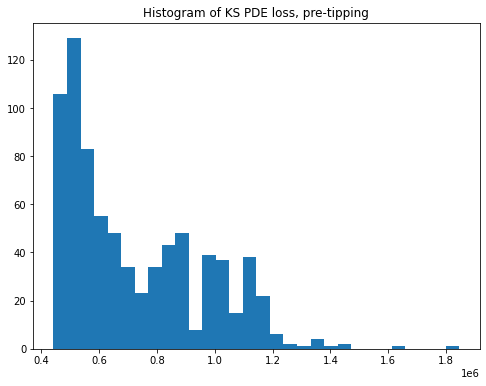

In [14]:
plt.figure(figsize=(8,6))
plt.hist(pde_loss_samples, bins=30)
plt.title("Histogram of KS PDE loss, pre-tipping")
plt.show()

In [15]:
ecdf = lambda x: np.sum(pde_loss_samples < x) / len(pde_loss_samples)

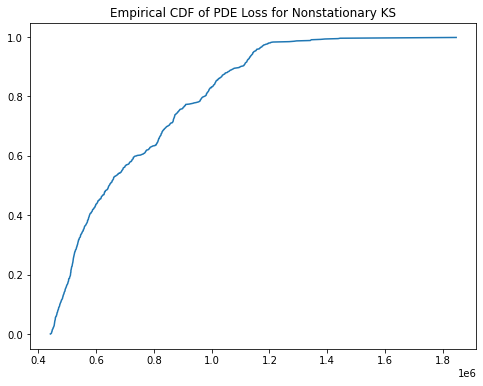

In [16]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(pde_loss_samples), np.linspace(0, 1, len(pde_loss_samples), endpoint=False))
plt.title("Empirical CDF of PDE Loss for Nonstationary KS")
plt.show()

# DKW analysis

We would like to bound the location of the true CDF $F(x)$ within some interval $F_n(x) - \varepsilon \leq F(x) \leq F_n(x) + \varepsilon$ of the empirical CDF $F_n(x)$ for all $x$. In fact, using the DKW inequality, we find that with probability $1 - \delta$, the true CDF $F(x)$ differs by at most $\varepsilon$ from $F_n(x)$.

In particular, the DKW inequality tells us that $$\varepsilon = \sqrt{\frac{\ln \frac{2}{\delta}}{2n}}.$$

In [17]:
delta = 1e-3

In [18]:
eps = np.sqrt(np.log(2 / delta) / (2 * len(pde_loss_samples)))
print(eps)

0.06980238800715442


In [19]:
alpha = 0.07

# Predicting tipping points

In [20]:
traj = test[0]

with torch.no_grad():
    t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt

    u = x_in = traj.permute(0, 1, 4, 2, 3)
    u = model.predict(x_in, comp_steps)
    u = u = u.permute(0, 1, 3, 4, 2)
    u = u.reshape((traj.shape[0], -1, n_x, dim))

    loss = PDE_loss(u, nu, t_mins, dt).numpy()

In [22]:
print("Offset from start caused by composing model:", comp_offset)

Offset from start caused by composing model: 16.0


In [23]:
tipping_time = np.inf
t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt # n_intervals warm up time

for loss_val, time in zip(loss, t_mins):
    if alpha >= 1 - ecdf(loss_val) + eps:
        tipping_time = time
        break

if tipping_time != np.inf:
    print("Predicted tipping point: %.2f" % tipping_time)
else:
    print("No tipping point found")

Predicted tipping point: 51.20


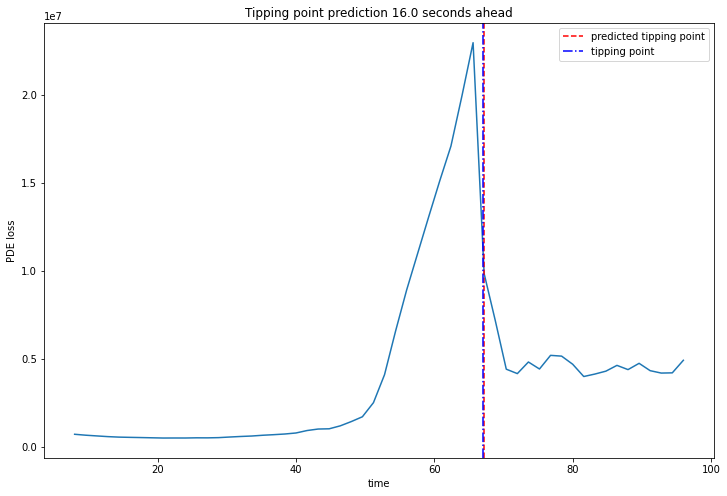

In [24]:
plt.figure(figsize=(12,8))
plt.plot(t_mins, loss)
plt.axvline(x = tipping_time + comp_offset, color='r', ls='--', label = 'predicted tipping point')
plt.axvline(x = tipping_point, color='b', ls='-.', label = 'tipping point')
plt.title("Tipping point prediction {} seconds ahead".format(comp_steps * dt * T))
plt.xlabel('time')
plt.ylabel('PDE loss')
plt.legend()
plt.show()

In [25]:
print("Error in tipping point prediction: %.2f" % ((tipping_time + comp_offset) - tipping_point))

Error in tipping point prediction: 0.20


# Paper Figures

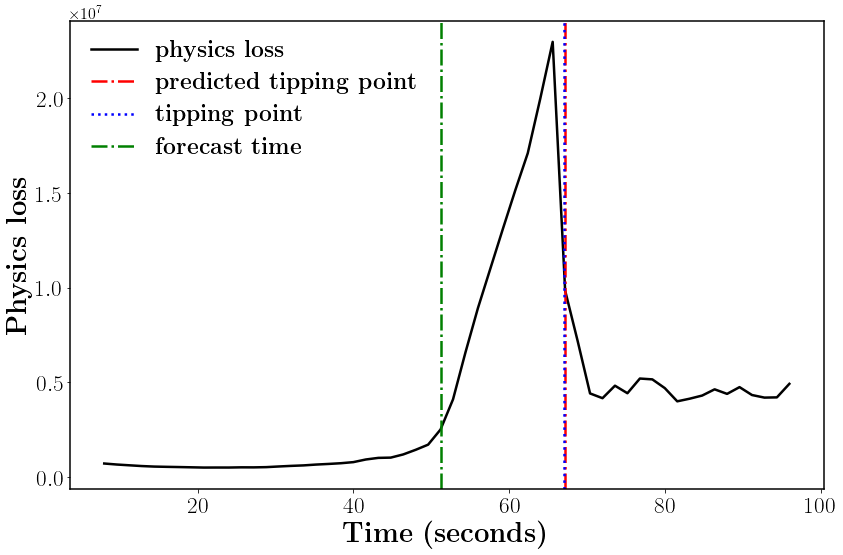

In [38]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
plt.figure(figsize=(12, 8))

# Plot the data
plt.plot(t_mins, loss, color='black', label=r'\textbf{physics loss}')
plt.axvline(x=tipping_time + comp_offset, color='r', ls='-.', label=r'\textbf{predicted tipping point}')
plt.axvline(x=tipping_point, color='b', ls='dotted', label=r'\textbf{tipping point}')
plt.axvline(x=tipping_time, color='green', ls='-.', label=r'\textbf{forecast time}')

# Set title and labels
#plt.title(r'\textbf{RNO tipping point prediction ' + str(comp_steps * dt * T) + ' seconds ahead}', fontsize='x-large')
plt.xlabel(r'\textbf{Time (seconds)}', fontsize='xx-large')
plt.ylabel(r'\textbf{Physics loss}', fontsize='xx-large')

# Customize legend
legend = plt.legend(loc='best', fontsize='x-large', frameon=False)
legend.get_frame().set_linewidth(0)

# Adjust tick label size
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')

# Show the plot
plt.tight_layout()
plt.show()

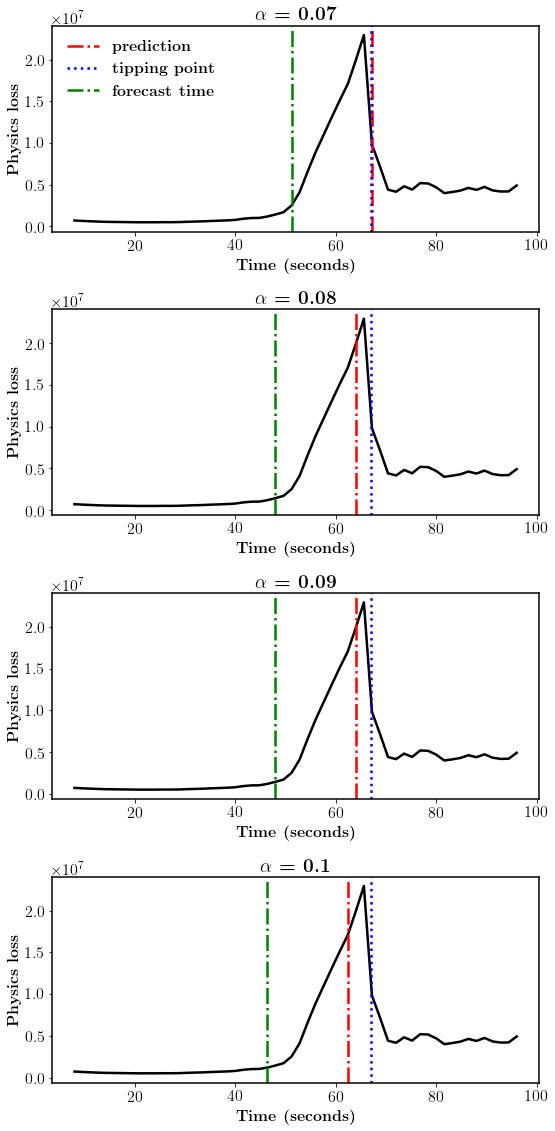

In [26]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
alphas = [0.07, 0.08, 0.09, 0.1]
fig, axs = plt.subplots(len(alphas), 1, figsize=(8, 16))

for i in range(len(alphas)):
    a = alphas[i]
    ax = axs[i]
    
    tipping_time = np.inf
    t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt # n_intervals warm up time

    for loss_val, time in zip(loss, t_mins):
        if a >= 1 - ecdf(loss_val) + eps:
            tipping_time = time
            break

    # Plot the data
    ax.plot(t_mins, loss, color='black')
    ax.axvline(x=tipping_time + comp_offset, color='r', ls='-.', label=r'\textbf{prediction}')
    ax.axvline(x=tipping_point, color='b', ls='dotted', label=r'\textbf{tipping point}')
    ax.axvline(x=tipping_time, color='green', ls='-.', label=r'\textbf{forecast time}')

    # Set title and labels
    ax.set_title(r'\textbf{$\alpha$ = ' + str(a) + ' }')
    ax.set_xlabel(r'\textbf{Time (seconds)}')
    ax.set_ylabel(r'\textbf{Physics loss}')
    
# Customize legend
legend = axs[0].legend(loc='upper left', frameon=False)
legend.get_frame().set_linewidth(0)    

# Show the plot
plt.tight_layout()
plt.show()

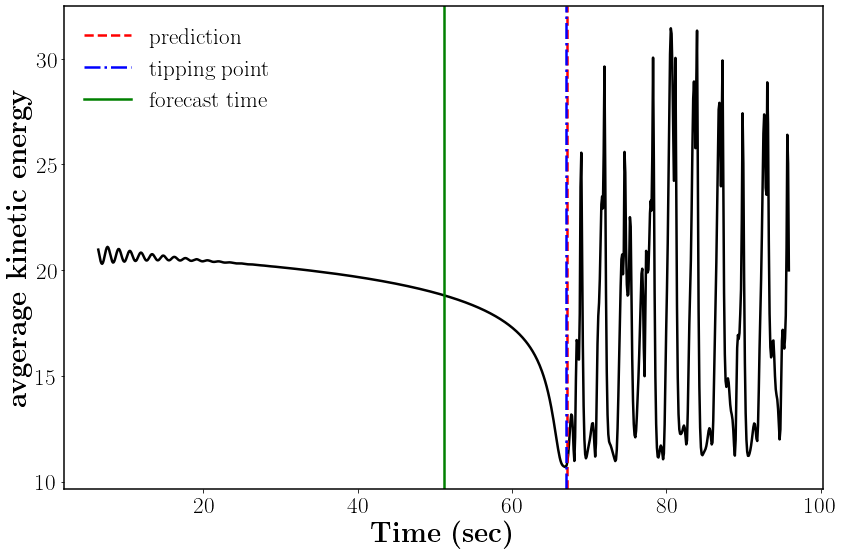

In [40]:
test_idx = 0

from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
temp = torch.reshape(test[test_idx,:,-1], (-1, n_x, dim)).numpy()
t = np.arange(T1, T2, dt)[:temp.shape[0]] + (n_intervals - 1) * T * dt

# Compute kinetic energy
mean_broadcast = np.broadcast_to(np.expand_dims(np.mean(temp, axis=1), axis=1), temp.shape)
temp = np.linalg.norm(temp - mean_broadcast, axis=-1)**2
temp = np.mean(temp, axis=-1)

t = t[(t.shape[0] - temp.shape[0]):]

# Create the first plot
fig, ax1 = plt.subplots(figsize=(12, 8))
line1 = ax1.plot(t, temp, 'black')
ax1.set_xlabel(r'\textbf{Time (sec)}', fontsize='xx-large')
ax1.set_ylabel(r'\textbf{avgerage kinetic energy}', fontsize='xx-large')
ax1.tick_params(labelsize='x-large')

line3 = ax1.axvline(x = tipping_time + comp_offset, color='r', ls='--', label = 'prediction')
line4 = ax1.axvline(x = tipping_point, color='b', ls='-.', label = 'tipping point')
line5 = ax1.axvline(x = tipping_time, color='g', ls='-', label = 'forecast time')

# Legend -- inspired from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = [line3] + [line4] + [line5]
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='best', fontsize='x-large')
legend.get_frame().set_linewidth(0)

# Show the plot
plt.tight_layout()

#plt.savefig('rno_tipping_ks_kinetic_energy.pdf', format='pdf')
plt.show()